In [37]:
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import torchvision.utils as tutils
from torchvision import datasets
from torchvision import transforms
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torch
import torchvision

In [38]:
h5 = h5py.File('/home/bhushan/college/CV/Thesis/Projects/lightestimation/Light-Estimation/LDAN/data/sfsNet/02/data_1.h5', 'r')
h5.keys()

IOError: Unable to open file (unable to open file: name = '/home/bhushan/college/CV/Thesis/Projects/lightestimation/Light-Estimation/LDAN/data/sfsNet/02/data_1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [39]:
h5 = h5py.File('/home/bhushan/college/CV/Thesis/Projects/lightestimation/LDAN/data/synImages/data_1.h5', 'r')
h5.keys()

IOError: Unable to open file (unable to open file: name = '/home/bhushan/college/CV/Thesis/Projects/lightestimation/LDAN/data/synImages/data_1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    

class CustomDataSetLoader(Dataset):
    def __init__(self, inData, transform = None):
        self.data = inData
        self.transform = transform
        #normalize here or in __getitem__

    def __getitem__(self, index):
        data = self.data[index]
        if self.transform is not None:
            data = self.transform(data)
        data = data.permute(1, 2, 0)
        return data

    def __len__(self):
        return len(self.data)
    
class DataSetNoPermute(Dataset):
    def __init__(self, inData, transform = None):
        self.data = inData
        self.transform = transform
        #normalize here or in __getitem__

    def __getitem__(self, index):
        data = self.data[index]
        if self.transform is not None:
            data = self.transform(data)
        data = data.permute(0, 2, 1)
        return data

    def __len__(self):
        return len(self.data)

def get_h5_file_names(path):
    h5Files = []
    for file in os.listdir(path):
        h5Files.append(path+file)
    return h5Files

def load_SfSNet_data(path, validation = False, batch_size = 64):
    h5Files = get_h5_file_names(path)
    if len(h5Files) == 0:
        print('NO H5 FILE FOUND FOR SYNTHETIC IMAGES', 'WARNING')
        return None

    # Load data from H5 Files
    firstTime = True
    for file in h5Files:
        hf = h5py.File(file, 'r')
        print hf.keys()
        albedo1 = hf['/Shading']
        rImg1 = hf['/SIRFS_Image']
        lighting1 = hf['/SIRFS_Lighting']
        normal1 = hf['/Normal']
        shading1 = hf['/Shading']
        true_normal1 = hf['/TrueNormal']
        mask1 = hf['/Mask']
        true_lighting1 = hf['/TrueLighting']
        # Following are not need for current experiment
        # PLEASE UNCOMMENT IF YOU NEED
        # height = hf['/Height']
        # reflectance = hf['/Reflectance']
        # finalLoss = hf['/FinalLoss']
        if firstTime:
            albedo = np.array(albedo1[:,:,:])
            rImage = np.array(rImg1[:,:,:])
            lighting = np.array(lighting1[:,:])
            normal = np.array(normal1[:,:,:])
            shading = np.array(shading1[:,:,:])
            true_normal = np.array(true_normal1[:,:,:])
            mask = np.array(mask1[:,:])
            true_lighting = np.array(true_lighting1[:,:])
            firstTime = False
        else:
            albedo = np.concatenate((albedo, np.array(albedo1[:,:,:])))
            rImage = np.concatenate((rImage, np.array(rImg1[:,:,:])))
            lighting = np.concatenate((lighting, np.array(lighting1[:,:])))
            normal = np.concatenate((normal, np.array(normal1[:,:,:])))
            shading = np.concatenate((shading, np.array(shading1[:,:,:])))
            true_normal = np.concatenate((true_normal, np.array(true_normal1[:,:,:])))
            mask = np.concatenate((mask, np.array(mask1[:,:])))
            true_lighting = np.concatenate((true_lighting, np.array(true_lighting1[:,:])))

    print('Size of Real data: ', rImage.shape, mask.shape, true_normal.shape)
    # Transforms being used
    transform = transforms.Compose([
            #transforms.Resize(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    
    noNormalize = transforms.Compose([
            #transforms.Resize(),
            transforms.ToTensor(),
    ])
        
    if validation:
        rImage_val, rImage = np.split(rImage, [batch_size])
        albedo_val, albedo = np.split(albedo, [batch_size])
        lighting_val, lighting = np.split(lighting, [batch_size])
        normal_val, normal = np.split(normal, [batch_size])
        shading_val, shading = np.split(shading, [batch_size])
        true_normal_val, true_normal = np.split(true_normal, [batch_size])
        mask_val, mask = np.split(mask, [batch_size])
        true_lighting_val, true_lighting = np.split(true_lighting, [batch_size])
        
        rImage_val = CustomDataSetLoader(rImage_val, transform = transform)
        albedo_val = CustomDataSetLoader(albedo_val, transform = transform)

        albedo_val = torch.utils.data.DataLoader(albedo_val, batch_size= batch_size, shuffle = False)
        real_image_val = torch.utils.data.DataLoader(rImage_val, batch_size= batch_size, shuffle = False)
        sirfs_sh_val = torch.utils.data.DataLoader(lighting_val, batch_size= batch_size, shuffle = False)
        sirfs_normal_val = torch.utils.data.DataLoader(normal_val, batch_size= batch_size, shuffle = False)
        sirfs_shading_val = torch.utils.data.DataLoader(shading_val, batch_size= batch_size, shuffle = False)
        true_normal_val = torch.utils.data.DataLoader(true_normal_val, batch_size= batch_size, shuffle = False)
        mask_val = torch.utils.data.DataLoader(mask_val, batch_size= batch_size, shuffle = False)
        true_lighting_val = torch.utils.data.DataLoader(true_lighting_val, batch_size= batch_size, shuffle = False)

    else:
        real_image_val = None
        sirfs_sh_val = None
        sirfs_normal_val = None
        sirfs_shading_val = None
        true_normal_val = None
        mask_val = None
        true_lighting_val = None
        albedo_val = None
    # Custom image dataset
    # Normal and Shading is already normalized by SIRFS method
    # So, Normalize only real images
    rImage = CustomDataSetLoader(rImage, transform = transform)
    albedo = CustomDataSetLoader(albedo, transform = transform)

    #mask = DataSetNoPermute(mask, transform = noNormalize)
    true_normal = CustomDataSetLoader(true_normal, transform = noNormalize)
    albedo = torch.utils.data.DataLoader(albedo, batch_size= batch_size, shuffle = False)
        
    realImage = torch.utils.data.DataLoader(rImage, batch_size= batch_size, shuffle = False)
    realSH = torch.utils.data.DataLoader(lighting, batch_size= batch_size, shuffle = False)
    rNormal = torch.utils.data.DataLoader(normal, batch_size= batch_size, shuffle = False)
    rShading = torch.utils.data.DataLoader(shading, batch_size= batch_size, shuffle = False)
    tNormal = torch.utils.data.DataLoader(true_normal, batch_size= batch_size, shuffle = False)
    mask = torch.utils.data.DataLoader(mask, batch_size= batch_size, shuffle = False)
    tSH = torch.utils.data.DataLoader(true_lighting, batch_size= batch_size, shuffle = False)
    
    print('Loading SFSNet Synthetic Images Completed')
    # Following are not need for current experiment
    # PLEASE UNCOMMENT IF YOU NEED
    # rHeight = torch.utils.data.DataLoader(height, batch_size= batch_size, shuffle = False)
    # rReflectance = torch.utils.data.DataLoader(reflectance, batch_size= batch_size, shuffle = False)
    # rFinalLoss = torch.utils.data.DataLoader(finalLoss, batch_size= batch_size, shuffle = False)
    return realImage, rNormal, realSH, rShading, tNormal, mask, tSH, albedo, real_image_val, sirfs_sh_val, sirfs_normal_val, sirfs_shading_val, true_normal_val, mask_val, true_lighting_val, albedo_val 



In [38]:
h5 = h5py.File('/home/bhushan/college/CV/Thesis/Projects/lightestimation/SIRFS/synImages/data_1.h5', 'r')
h5.keys()

[u'FinalLoss',
 u'Height',
 u'Image',
 u'Lighting',
 u'Mask',
 u'Normal',
 u'Reflectance',
 u'Shading',
 u'TrueLighting',
 u'TrueNormal']

In [39]:
# image = np.array(h5['Image'][:,:,:])
# show(image)
# /home/bhushan/college/CV/Thesis/Projects/lightestimation/SIRFS/test/t1/

In [7]:
# realImage, rNormal, realSH, rShading, tNormal, mask, tSH, albedo, real_image_val, sirfs_sh_val, sirfs_normal_val, sirfs_shading_val, true_normal_val, mask_val, true_lighting_val, albedo_val = load_SfSNet_data('./data/sfsNet/00/')

In [43]:
import dataLoading  #~/college/CV/Thesis/Projects/lightestimation/SIRFS/synImages
real_image, real_normal, real_sh, real_shading, mask, sirfs_shading, sirfs_normal, sirfs_sh, real_image_val, real_normal_val, real_lighting_val, real_shading_val, mask_val, sirfs_shading_val, sirfs_normal_val, sirfs_sh_val  = dataLoading.load_SfSNet_data('../data/AE/syn/', validation = True)

[u'Image', u'Lighting', u'Mask', u'Normal', u'SIRFS_FinalLoss', u'SIRFS_Height', u'SIRFS_Lighting', u'SIRFS_Normal', u'SIRFS_Reflectance', u'SIRFS_Shading', u'Shading']
[u'Image', u'Lighting', u'Mask', u'Normal', u'SIRFS_FinalLoss', u'SIRFS_Height', u'SIRFS_Lighting', u'SIRFS_Normal', u'SIRFS_Reflectance', u'SIRFS_Shading', u'Shading']
('Size of Real data: ', (600, 3, 64, 64), (600, 3, 64, 64), (600, 3, 64, 64))
Loading SFSNet Synthetic Images Completed


In [67]:
rImageIter = iter(real_image)

In [71]:
len(rImageIter)

9

In [69]:
cnt = 0
while cnt < len(rImageIter):
    cnt += 1
    a = next(rImageIter)

In [70]:
print cnt

9


torch.Size([64, 64, 3, 64])
torch.Size([64, 3, 64, 64])


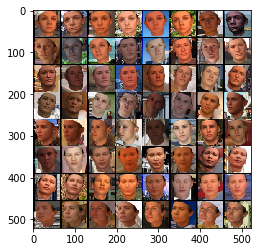

In [55]:
albedo = next(rImageIter)
print(albedo.shape)
albedo = albedo.permute(0, 2, 3, 1)
print(albedo.shape)
show(torchvision.utils.make_grid(albedo, padding=1))

In [119]:
albedo = next(iter(real_shading))
print(albedo.shape)
albedo.permute([0, 2, 1, 3])
print(albedo.size())
show(torchvision.utils.make_grid(albedo, padding=1))

torch.Size([64, 64, 3, 64])


AssertionError: Invalid permutation

In [47]:
dreal = next(iter(tSH))
print(dreal)


 5.6125e-01  2.1644e-01 -2.8254e-01  ...  -7.7570e-03  1.6838e-01  6.2620e-03
 7.4425e-01  2.6316e-01 -5.9575e-01  ...   3.9590e-03  1.8784e-01  8.8270e-03
 4.7476e-01  1.3748e-01 -2.6540e-01  ...  -5.7631e-02 -5.1511e-02 -1.5789e-01
                ...                   ⋱                   ...                
 5.3036e-01  1.3494e-01  3.9648e-02  ...   3.1768e-02  3.9943e-02  1.1513e-02
 9.3321e-01  1.5193e-01  1.5210e-01  ...  -1.0311e-01 -5.2910e-03 -1.0756e-02
 7.6495e-01  1.5985e-01 -3.0019e-01  ...   5.9129e-02  5.8567e-02  2.3429e-01
[torch.DoubleTensor of size 64x27]



In [48]:
# plt.imshow(mask[10], interpolation='nearest')
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

torch.Size([64, 3, 64, 64])


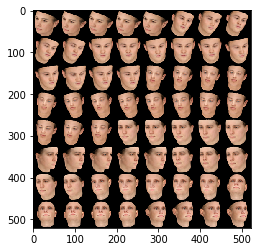

In [49]:
albedo = next(iter(albedo))
print(albedo.size())
show(torchvision.utils.make_grid(albedo, padding=1))

torch.Size([64, 3, 64, 64])


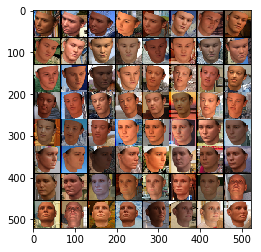

In [50]:
dreal = next(iter(realImage))
print(dreal.size())
show(torchvision.utils.make_grid(dreal, padding=1))

In [86]:
mk = next(iter(mask))
print(mk.size())
show(torchvision.utils.make_grid(mk * 255, padding=1))
#plt.imshow(torchvision.utils.make_grid(dreal, padding=1), interpolation='nearest')

torch.Size([64, 64, 3, 64])


RuntimeError: inconsistent tensor size, expected tensor [3 x 3 x 64] and src [64 x 3 x 64] to have the same number of elements, but got 576 and 12288 elements respectively at /opt/conda/conda-bld/pytorch-cpu_1518280788456/work/torch/lib/TH/generic/THTensorCopy.c:86

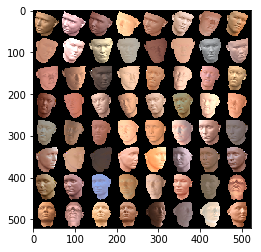

In [55]:
out = dreal.type(torch.DoubleTensor) * mk.type(torch.DoubleTensor)
show(torchvision.utils.make_grid(out/albedo.type(torch.DoubleTensor), padding=1))

In [ ]:
dreal = next(iter(realImage))
print(dreal.size())
show(torchvision.utils.make_grid(dreal, padding=1))

torch.Size([64, 3, 64, 64])


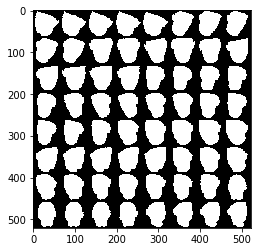

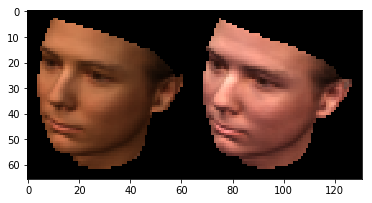

In [25]:
out = dreal.type(torch.DoubleTensor) * mk.type(torch.DoubleTensor)
show(torchvision.utils.make_grid(out, padding=1))

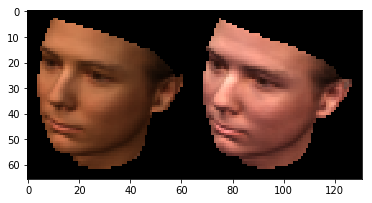

In [23]:
ans = torch.mul(dreal.type(torch.DoubleTensor), mk.type(torch.DoubleTensor))
show(torchvision.utils.make_grid(ans, padding=1))

In [34]:
import dataLoading
real_image, real_normal, real_sh, real_shading, mask, sirfs_shading, sirfs_normal, sirfs_sh, real_image_val, real_normal_val, real_lighting_val, real_shading_val, mask_val, sirfs_shading_val, sirfs_normal_val, sirfs_sh_val  = dataLoading.load_SfSNet_data('/home/bhushan/college/CV/Thesis/Projects/lightestimation/SIRFS/synImages/0/', batch_size = 1)

[u'Image', u'Lighting', u'Mask', u'Normal', u'SIRFS_FinalLoss', u'SIRFS_Height', u'SIRFS_Lighting', u'SIRFS_Normal', u'SIRFS_Reflectance', u'SIRFS_Shading', u'Shading']
('Size of Real data: ', (1, 3, 64, 64), (1, 3, 64, 64), (1, 3, 64, 64))
Loading SFSNet Synthetic Images Completed


In [35]:
dreal = next(iter(real_image))
print(dreal.size())
show(torchvision.utils.make_grid(dreal, padding=1))

torch.Size([1, 64, 3, 64])


RuntimeError: inconsistent tensor size, expected tensor [3 x 3 x 64] and src [64 x 3 x 64] to have the same number of elements, but got 576 and 12288 elements respectively at /opt/conda/conda-bld/pytorch-cpu_1518280788456/work/torch/lib/TH/generic/THTensorCopy.c:86

In [ ]:
print(mk[10].shape)
#plt.imshow(dreal[10], interpolation='nearest')
show(mk[10])

In [ ]:
normal = next(iter(tNormal))
print(normal.size())
show(torchvision.utils.make_grid(normal, padding=1))

In [ ]:
tsh = next(iter(tSH))
print(tsh.size())
#show(torchvision.utils.make_grid(normal, padding=1))

In [ ]:
print(normal[10].shape)
#plt.imshow(dreal[10], interpolation='nearest')
show(normal[10])

In [ ]:
print(normal[10].max())

In [ ]:
mask = h5['mask']

In [ ]:
print(h5['mask'][10].shape)

In [ ]:
#plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
h5 = h5py.File('paths/data_1.h5', 'r')
plt.imshow(h5['mask'][10], interpolation='nearest')

In [ ]:
sh = h5['trueLighting']

In [ ]:
sh.shape

In [ ]:
sh[0]

In [ ]:
from shading import *

In [ ]:
outShadingB = ShadingFromDataLoading(tNormal, tSH) #, shadingFromNet = True)
#outShadingB = denorm(outShadingB)
#outShadingB = applyMask(outShadingB, real_image_mask)
outShadingB = outShadingB.data
pic = torchvision.utils.make_grid(outShadingB, padding=1)


In [ ]:
show(pic)

In [63]:
import dataLoading

In [65]:
real_image, real_normal, real_sh, real_shading, mask, sirfs_shading, sirfs_normal, sirfs_sh, real_image_val, real_normal_val, real_lighting_val, real_shading_val, mask_val, sirfs_shading_val, sirfs_normal_val, sirfs_sh_val  = dataLoading.load_SfSNet_data('./data/sfsNet/', validation = True, twoLevel = True)

[u'Image', u'Lighting', u'Mask', u'Normal', u'SIRFS_FinalLoss', u'SIRFS_Height', u'SIRFS_Lighting', u'SIRFS_Normal', u'SIRFS_Reflectance', u'SIRFS_Shading', u'Shading']
('Size of Real data: ', (300, 3, 64, 64), (300, 3, 64, 64), (300, 3, 64, 64))
Loading SFSNet Synthetic Images Completed


In [67]:
real_image_mask_test = next(iter(mask_val))
show(torchvision.utils.make_grid(real_image_mask_test*255, padding=1))

RuntimeError: inconsistent tensor size, expected tensor [3 x 3 x 64] and src [64 x 3 x 64] to have the same number of elements, but got 576 and 12288 elements respectively at /opt/conda/conda-bld/pytorch-cpu_1518280788456/work/torch/lib/TH/generic/THTensorCopy.c:86

In [81]:
import shading
from utils import *
IS_CUDA = False
from torch.autograd import Variable

def var(x):
    if IS_CUDA:
        x = x.cuda()
    return Variable(x)

tmp = next(iter(real_image_val))
#tmp = denorm(tmp)
#tmp = shading.applyMask(var(tmp).type(torch.DoubleTensor), real_image_mask_test)
show(torchvision.utils.make_grid(tmp, padding=1))


RuntimeError: inconsistent tensor size, expected tensor [3 x 3 x 64] and src [64 x 3 x 64] to have the same number of elements, but got 576 and 12288 elements respectively at /opt/conda/conda-bld/pytorch-cpu_1518280788456/work/torch/lib/TH/generic/THTensorCopy.c:86

In [ ]:


# Transforms being used
#if SHOW_IMAGES:


tmp = next(iter(syn_image1))
utils.save_image(torchvision.utils.make_grid(tmp, padding=1), output_path+'images/test_synthetic_img.png')


tmp = next(iter(real_normal_val))
#tmp = denorm(tmp)
tmp = applyMask(var(tmp), real_image_mask_test)
utils.save_image(torchvision.utils.make_grid(tmp.data, padding=1), output_path+'images/test_real_normal.png')


tmp = next(iter(sirfs_normal_val))
#tmp = denorm(tmp)
tmp = applyMask(var(tmp), real_image_mask_test)
utils.save_image(torchvision.utils.make_grid(tmp.data, padding=1), output_path+'images/test_sirf_normal.png')

tmp = next(iter(sirfs_shading_val))
tmp = denorm(tmp)
tmp = applyMask(var(tmp), real_image_mask_test)
utils.save_image(torchvision.utils.make_grid(tmp.data, padding=1), output_path+'images/test_sirf_shading.png')


tmp = next(iter(real_shading_val))
tmp = denorm(tmp)
tmp = applyMask(var(tmp), real_image_mask_test)
utils.save_image(torchvision.utils.make_grid(tmp.data, padding=1), output_path+'images/test_real_shading.png')

